# Windows 10 Coin

train:  (row: 1,347,190, columns: 1,085)
test:   (row:   374,136, columns: 1,084)

y value: if HasClicked == True, app 1.8%

How to run
1. Put the train and test files in ..\input
2. Put the script file in ..\script
3. In Jupyter, run all and get submission file in the same script folder

In [117]:
# Timer and file info
import math
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc # We're gonna be clearing memory a lot
import matplotlib.pyplot as plt
import seaborn as sns
import random
from ml_metrics import mapk
from datetime import datetime
import re
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import matthews_corrcoef, f1_score, classification_report, confusion_matrix, precision_score, recall_score
%matplotlib inline

# Timer
class Timer:
    def __init__(self, text=None):
        self.text = text
        
    def __enter__(self):
        self.cpu = time.clock()
        self.time = time.time()
        if self.text:
            print("{}...".format(self.text))
            print(datetime.now())
        return self

    def __exit__(self, *args):
        self.cpu = time.clock() - self.cpu
        self.time = time.time() - self.time
        if self.text:
            print("%s: cpu %0.2f, time %0.2f\n" % (self.text, self.cpu, self.time))

# Split to train and holdout sets with counts
def sample_train_holdout(_df, sample_count, holdout_count):   
    random.seed(7)
    sample_RowNumber = random.sample(list(_df['RowNumber']), (sample_count + holdout_count))
    train_RowNumber = random.sample(sample_RowNumber, sample_count)
    holdout_RowNumber = list(set(sample_RowNumber) - set(train_RowNumber))
    holdout = _df[_df['RowNumber'].isin(holdout_RowNumber)].copy()
    _df = _df[_df['RowNumber'].isin(train_RowNumber)]
    return _df, holdout 

# Sampling for train and holdout with imbalanced binary label
def trainHoldoutSampling(_df, _id, _label, _seed=7, t_tr=0.5, t_ho=0.5, f_tr=0.05, f_ho=0.5):
    random.seed(_seed)
    
    positive_id = list(_df[_df[_label]==True][_id].values)
    negative_id = list(_df[_df[_label]==False][_id].values)
    
    train_positive_id = random.sample(positive_id, int(len(positive_id) * t_tr))
    holdout_positive_id = random.sample(list(set(positive_id)-set(train_positive_id)), int(len(positive_id) * t_ho)) 
    train_negative_id = random.sample(negative_id, int(len(negative_id) * f_tr))
    holdout_negative_id = random.sample(list(set(negative_id)-set(train_negative_id)), int(len(negative_id) * f_ho))
    
    train_id = list(set(train_positive_id)|set(train_negative_id))
    holdout_id = list(set(holdout_positive_id)|set(holdout_negative_id))
    
    print('train count: {}, train positive count: {}'.format(len(train_id),len(train_positive_id)))
    print('holdout count: {}, holdout positive count: {}'.format(len(holdout_id),len(holdout_positive_id)))
    
    return _df[_df[_id].isin(train_id)], _df[_df[_id].isin(holdout_id)]

def datetime_features2(_df, _col):
    _format='%m/%d/%Y %I:%M:%S %p'
    _df[_col] = _df[_col].apply(lambda x: datetime.strptime(x, _format))
    
    colYear = _col+'Year'
    colMonth = _col+'Month'
    colDay = _col+'Day'
    colHour = _col+'Hour'
    #colYearMonthDay = _col+'YearMonthDay'
    #colYearMonthDayHour = _col+'YearMonthDayHour' 
    
    _df[colYear] = _df[_col].apply(lambda x: x.year)
    _df[colMonth] = _df[_col].apply(lambda x: x.month)
    _df[colDay] = _df[_col].apply(lambda x: x.day)
    _df[colHour] = _df[_col].apply(lambda x: x.hour)
    
    #ymd = [colYear, colMonth, colDay]
    #ymdh = [colYear, colMonth, colDay, colHour]
    
    #_df[colYearMonthDay] = _df[ymd].apply(lambda x: '_'.join(str(x)), axis=1)
    #_df[colYearMonthDayHour] = _df[ymdh].apply(lambda x: '_'.join(str(x)), axis=1)

    return _df
    
# Change date column datetime type and add date time features
def datetime_features(_df, _col, isDelete = False):
    # 1. For years greater than 2017, create year folder with regex and change year to 2017 in datetime column
    # find and return 4 digit number (1st finding) in dataframe string columns
    year_col = _col + 'Year'
    _df[year_col] = _df[_col].apply(lambda x: int(re.findall(r"\D(\d{4})\D", " "+ str(x) +" ")[0]))
    years = sorted(list(_df[year_col].unique()))
    yearsGreaterThan2017 = sorted(i for i in years if i > 2017)

    # Two ways for strange year data (1) change it to 2017 temporarily (2) remove from data; we will go with (1)
    # because we cannot remove test rows anyway
    if isDelete:
        _df = _df[~_df[year_col].isin(yearsGreaterThan2017)]
    else:
        for i in yearsGreaterThan2017:
            print("replace ", i, " to 2017 for conversion")
            _df.loc[_df[year_col] == i, _col] = _df[_df[year_col] == i][_col].values[0].replace(str(i), "2017")
    
    # How to remove strange year rows
    # train = train[~train['year'].isin(yearsGreaterThan2017)]

    # 2. Convert string to datetime
    _df[_col] = pd.to_datetime(_df[_col])
    print(_col, "column conversion to datetime type is done")
    
    # 3. Add more date time features
    month_col = _col + 'Month'
    week_col = _col + 'Week'
    weekday_col = _col + 'Weekday'
    day_col = _col + 'Day'
    hour_col = _col + 'Hour'
    #year_month_day_col = _col + 'YearMonthDay'
    #year_month_day_hour_col = _col + 'YearMonthDayHour'
    
    _df[month_col] = pd.DatetimeIndex(_df[_col]).month
    _df[week_col] = pd.DatetimeIndex(_df[_col]).week
    _df[weekday_col] = pd.DatetimeIndex(_df[_col]).weekday
    _df[day_col] = pd.DatetimeIndex(_df[_col]).day
    _df[hour_col] = pd.DatetimeIndex(_df[_col]).hour
    #_df[year_month_day_col] = _df[[year_col, month_col, day_col]].apply(lambda x: ''.join(str(x)), axis=1)
    #_df[year_month_day_hour_col] = _df[[year_col, month_col, day_col, hour_col]].apply(lambda x: ''.join(str(x)), axis=1)
    print("year, month, week, weekday, day, hour features are added")
    
    return _df

# Delete rows with list condition for dataframe
def delRows(_df, _col, _list):
    _df = _df[~_df[_col].isin(_list)]
    return _df

import re

# Create new column using regex pattern for strings for dataframe
def addFeatureRegex(_df, _col, _newCol):
    _df[_newCol] = _df[_col].apply(lambda x: int(re.findall(r"\D(\d{4})\D", " "+ str(x) +" ")[0]))
    return _df

# Convert string to datetime type
def stringToDatetime(_df, _col):
    _df[_col] = _df[_col].astype('datetime64[ns]')
    return _df

# Add features from datetime
def addDatetimeFeatures(_df, _col):
    _df[_col + 'Year'] = pd.DatetimeIndex(_df[_col]).year
    _df[_col + 'Month'] = pd.DatetimeIndex(_df[_col]).month
    _df[_col + 'Week'] = pd.DatetimeIndex(_df[_col]).week
    _df[_col + 'Weekday'] = pd.DatetimeIndex(_df[_col]).weekday
    _df[_col + 'Day'] = pd.DatetimeIndex(_df[_col]).day
    _df[_col + 'Hour'] = pd.DatetimeIndex(_df[_col]).hour
    return _df

# Get categorical column names
def categoricalColumns(_df):
    cat_columns = _df.select_dtypes(['object']).columns
    print("Categorical column count:", len(cat_columns))
    print("First 5 values:", cat_columns[:5])
    return cat_columns

# Get column names starting with
def columnsStartingWith(_df, _str):
    sorted_list = sorted(i for i in list(_df) if i.startswith(_str))
    print("Column count:", len(sorted_list))
    print("First 5 values:", sorted_list[:5])    
    return sorted_list

# Get column names ending with
def columnsEndingWith(_df, _str):
    sorted_list = sorted(i for i in list(_df) if i.endswith(_str))
    print("Column count:", len(sorted_list))
    print("First 5 values:", sorted_list[:5])    
    return sorted_list

# Get constant columns
def constantColumns(_df):
    constant_list = []
    cols = list(_df) # same as _df.columns.values
    for col in cols:
        if len(_df[col].unique()) == 1:
            constant_list.append(col)
    print("Constant column count:", len(constant_list))
    print("First 5 values:", constant_list[:5])  
    return constant_list

# Add null columns
def makeNullColumns(_df, _cols):
    null_df = _df[_cols].isnull()
    null_df.columns = null_df.columns + 'Null'
    _df = pd.concat([_df, null_df], axis=1)
    return _df

# Union
def union(a, b):
    return list(set(a)|set(b))

def unique(a):
    return list(set(a))

# undersampling - sample rate 0.8 for 80% samling using isUndersampled column 
def underSampling(_df, _sample_rate):
    _df['isUnderSampled'] = 1
    _rand_num = 1/(1-_sample_rate)
    underSample = np.random.randint(_rand_num, size=len(_df[_df['HasClicked'] == 0]))
    _df.loc[_df['HasClicked'] == 0, 'isUnderSampled'] = underSample>0
    return _df

# Add column with value count
def valueCountColumn(_df, _col):
    _dict = dict([(i, a) for i, a in zip(_df[_col].value_counts().index, _df[_col].value_counts().values)])
    _df[_col+'ValueCount'] = _df[_col].apply(lambda x: _dict[x])
    return _df

# Add column with bool values to check if keyword is contained or not
def containColumn(_df, _col, _str):
    _df[_col+'Cotains'+_str] = _df[_col].str.contains(_str)
    return _df

# Feature engineering
def feature_engineering(_df):
    print("shape:", _df.shape)
    print("Add datetime features...")
    datetime_columns = ['BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime']
    for col in datetime_columns:
        print(col)
        if _df[col].isnull().sum() > 0:
            _df[col] = _df[col].fillna('1/1/2017 11:11:11 AM')
        _df = datetime_features2(_df, col)

    print("shape:", _df.shape)

    gc.collect()
    
    # Null count
    print("Missing value count...")
    _df['CntNs'] = _df.isnull().sum(axis=1) 

    cols = ['AppCategoryNMinus1', 'AppCategoryNMinus2', 'AppCategoryNMinus3', 'AppCategoryNMinus4', 'AppCategoryNMinus5',
           'AppCategoryNMinus6', 'AppCategoryNMinus7', 'AppCategoryNMinus8']
    _df['AppCatCntNs'] = _df[cols].isnull().sum(axis=1)

    #_df[cols] = _df[cols].fillna("NA")
    #for col in cols:
    #    print(col)
    #    _df[col+'HighLevel'] = _df[col].apply(lambda x: str(x).split(':')[0])
   
    # Game segment parse with '.'
    # to-do: 2nd and 3rd parsed values to add as features later, some exception handling is needed
    print("Gamer segment parsing...")
    _df['GamerSegment1'] = _df['GamerSegment'].apply(lambda x: str(x).split('.')[0] if str(x).split('.') else 'Unknown')
    
    # Check creativeName contains keyword or not
    print("CreativeName contains a keyword...")
    keywords = ['SL', 'TS', 'Week7', 'Week 7', 'Meet', 'Skype', 'Battery', 'Switch', 'Performance', 'Security', 
                'Surge', 'Publish', 'Rewards', 'Aggressive', 'Edge', 'Chrome', 'Firefox', 'Discover', 'Free']
    for keyword in keywords:
        _df = containColumn(_df, 'creativeName', keyword)
    #_df['week7'] = _df['Week7'].values + _df['Week 7'].values
    #_df.drop(['Week7', 'Week 7'], axis = 1, inplace = True)
    
    # Convert categorical columns to numeric
    print("Convert categorical columns to numeric...")
    cat_columns = _df.select_dtypes(['object']).columns
    for cat_column in cat_columns:
        print(cat_column)
        if cat_column == 'creativeName':
            _df['creativeNameTest'] = _df['creativeName'].values
        _df[cat_column] = _df[cat_column].apply(lambda x: abs(hash(x)))
    gc.collect()
    
    # Replace missing values with -1
    print("Replace missing values with -1")
    _df = _df.fillna(-1)
    
    # Value count
    print("Value count...")
    cols = ['UniqueUserDeviceKey', 'CampaignId']
    for col in cols:
        print(col)
        _df = valueCountColumn(_df, col)
        
    return _df

# Get best threshold value for F1 score
def f1_best_threshold(_actual, _pred):
    thresholds = np.linspace(0.01, 0.2, 500)

    fc = np.array([f1_score(_actual, _pred>thr) for thr in thresholds])
    plt.plot(thresholds, fc)
    best_threshold = thresholds[fc.argmax()]
    print('f1 score:', fc.max())
    print('best threshold:', best_threshold)
    print('TF pred mean:', (_pred>best_threshold).mean())
    
    return best_threshold

In [109]:
with Timer("Read train data..."):
    train = pd.read_csv('../input/CoinMlCompetitionSoftlandingTrainWithHeader.tsv', sep='\t') # (1347190, 1085)
    print(train.shape)
    
    test_header = train.columns[0:1084]
    
    # Before deleting some columns, get missing value count
    train['TotalNulls'] = train.isnull().sum(axis=1) 
    
    # Reduce size by removing most of days and time features
    features = train.columns
    
    print("features without time_ and days_ columns")
    time_columns = columnsStartingWith(train, 'Time_')
    days_columns = columnsStartingWith(train, 'Days_')
    features = list(set(features) - set(time_columns))
    features = list(set(features) - set(days_columns))
    
    # Add important time features from feature importance above 50 and some validation
    imp_time_features = ['Time_Accessibility', 'Time_Browser', 'Time_Communications', 'Time_Content', 'Time_DevTools', 
                         'Time_Games', 'Time_Malware', 'Time_Media', 'Time_PersonalProductivity', 'Time_Readers', 
                         'Time_Search', 'Time_Social', 'Time_StudentAndLearning', 'Time_ModernApps', 
                         'Time_Games_Core', 'Time_Games_Casual', 'Time_windows_immersivecontrolpanel',
                         'Time_msascui_exe', 'Time_chrome_exe', 'Time_microsoft_windows_cortana', 'Time_lockapphost_exe',
                         'Time_excel_exe','Time_consent_exe','Time_explorer_exe',
                         'Time_applicationframehost_exe','Time_conhost_exe','Time_csrss_exe',
                         'Time_microsoft_microsoftedge','Time_onedrive_exe',
                         'Time_dwm_exe','Time_rundll32_exe','Time_setup_exe','Time_winword_exe',
                         'Time_dllhost_exe','Time_logonui_exe','Time_microsoft_lockapp',
                         'Time_microsoft_windows_photos','Time_powerpnt_exe',
                         'Time_pickerhost_exe','Time_werfault_exe','Time_iexplore_exe',
                         'Time_taskmgr_exe','Time_softwareupdate_exe',
                         'Time_microsoft_getstarted','Time_idman_exe','Time_firefox_exe',
                         'Time_microsoft_windowsstore','Time_notepad_exe']
    features = list(set(features) | set(imp_time_features))
    
    train = train[features]
    print(train.shape)

Read train data......
2017-03-20 23:34:17.890596


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,8,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1347190, 1085)
features without time_ and days_ columns
Column count: 517
First 5 values: ['Time_0c72c7cd_217379cb4ae6f', 'Time_0c72c7cd_beta', 'Time_123freesolitaire_exe', 'Time_1cv8_exe', 'Time_2345explorer_exe']
Column count: 517
First 5 values: ['Days_0c72c7cd_217379cb4ae6f', 'Days_0c72c7cd_beta', 'Days_123freesolitaire_exe', 'Days_1cv8_exe', 'Days_2345explorer_exe']
(1347190, 100)
Read train data...: cpu 176.50, time 176.51



In [110]:
# Train feature engineering
with Timer("Train feature engineering..."):
    #train = feature_engineering(train, isDeleteOddDateRows=True)
    train = feature_engineering(train)
    
    train_y = train['HasClicked'].values
    print("train y mean:", train_y.mean())

Train feature engineering......
2017-03-20 23:37:25.127464
shape: (1347190, 100)
Add datetime features...
BubbleShownTime
FirstUpdatedDate
OSOOBEDateTime
shape: (1347190, 112)
Missing value count...
Gamer segment parsing...
CreativeName contains a keyword...
Convert categorical columns to numeric...
creativeName
CampaignId
AppCategoryNMinus3
DeviceTimezone
GamerSegment
IsVirtualDevice
AppCategoryNMinus1
AppCategoryNMinus7
AppCategoryNMinus8
IsAlwaysOnAlwaysConnectedCapable
BubbleShownTime
AppCategoryNMinus5
IsDomainJoined
DefaultInternetBrowser
GamerPCClassification
AppCategoryNMinus6
DisplayLanguage
OSOOBEDateTime
ISOCountryShortName
AppCategoryNMinus4
AppCategoryNMinus2
GamerSegment1
creativeNameCotainsSL
creativeNameCotainsTS
creativeNameCotainsWeek7
creativeNameCotainsWeek 7
creativeNameCotainsMeet
creativeNameCotainsSkype
creativeNameCotainsBattery
creativeNameCotainsSwitch
creativeNameCotainsPerformance
creativeNameCotainsSecurity
creativeNameCotainsSurge
creativeNameCotainsPubli

In [111]:
with Timer("Read test and feature engineering..."):
    # Read tsv file
    test = pd.read_csv('../input/CoinMlCompetitionSoftlandingEvaluateNoLabel.tsv', sep='\t', header = None)
    
    # Add header because test does not header
    test.columns = test_header

    # Before deleting some columns, get missing value count
    test['TotalNulls'] = test.isnull().sum(axis=1)    
    
    # Reduce test size by leaving train features only
    test = test[list(set(features) - set(['HasClicked']))]
    
    # Feature engineering - should not delete odd date rows
    #test = feature_engineering(test, isDeleteOddDateRows=False)
    test = feature_engineering(test)
    
    print(test.shape)

Read test and feature engineering......
2017-03-20 23:39:26.370879


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape: (374137, 99)
Add datetime features...
BubbleShownTime
FirstUpdatedDate
OSOOBEDateTime
shape: (374137, 111)
Missing value count...
Gamer segment parsing...
CreativeName contains a keyword...
Convert categorical columns to numeric...
creativeName
CampaignId
AppCategoryNMinus3
DeviceTimezone
GamerSegment
AppCategoryNMinus1
AppCategoryNMinus7
AppCategoryNMinus8
AppCategoryNMinus5
IsAlwaysOnAlwaysConnectedCapable
BubbleShownTime
IsDomainJoined
DefaultInternetBrowser
GamerPCClassification
AppCategoryNMinus6
DisplayLanguage
ISOCountryShortName
AppCategoryNMinus4
AppCategoryNMinus2
GamerSegment1
creativeNameCotainsSL
creativeNameCotainsTS
creativeNameCotainsWeek7
creativeNameCotainsWeek 7
creativeNameCotainsMeet
creativeNameCotainsSkype
creativeNameCotainsBattery
creativeNameCotainsSwitch
creativeNameCotainsPerformance
creativeNameCotainsSecurity
creativeNameCotainsSurge
creativeNameCotainsPublish
creativeNameCotainsRewards
creativeNameCotainsAggressive
creativeNameCotainsEdge
creativeN

In [112]:
# Get column groups and features
all_columns = train.columns
print("All columns:", len(all_columns))

# Remove constant columns for train (all included in time_ and days_ columns)
print("features without constant columns")
constant_columns = constantColumns(train)
features = list(set(all_columns) - set(constant_columns))
print("features:", len(features))

# With a lot of nulls, exclude time and days columns first and add later for improvement
#print("features without time_ and days_ columns")
#time_columns = columnsStartingWith(train, 'Time_')
#days_columns = columnsStartingWith(train, 'Days_')
#features = list(set(features) - set(time_columns))
#features = list(set(features) - set(days_columns))

# Drop features
drop_features = ['HasClicked', 'RowNumber', 'BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime', 'creativeNameTest'] 
features = list(set(features) - set(drop_features))

print("Final features:", len(features))

All columns: 137
features without constant columns
Constant column count: 0
First 5 values: []
features: 137
Final features: 131


In [113]:
sorted(features)

['AppCatCntNs',
 'AppCategoryNMinus1',
 'AppCategoryNMinus2',
 'AppCategoryNMinus3',
 'AppCategoryNMinus4',
 'AppCategoryNMinus5',
 'AppCategoryNMinus6',
 'AppCategoryNMinus7',
 'AppCategoryNMinus8',
 'BubbleShownTimeDay',
 'BubbleShownTimeHour',
 'BubbleShownTimeMonth',
 'BubbleShownTimeYear',
 'CampaignId',
 'CampaignIdValueCount',
 'CntNs',
 'DefaultInternetBrowser',
 'DeviceTimezone',
 'DisplayLanguage',
 'FirstUpdatedDateDay',
 'FirstUpdatedDateHour',
 'FirstUpdatedDateMonth',
 'FirstUpdatedDateYear',
 'FrontFacingCameraResolution',
 'GamerPCClassification',
 'GamerSegment',
 'GamerSegment1',
 'HasFrontFacingCamera',
 'HasRearFacingCamera',
 'ISOCountryShortName',
 'InternalBatteryNumberOfCharges',
 'InternalPrimaryDiagonalDisplaySizeInInches',
 'InternalPrimaryDisplayLogicalDPIX',
 'InternalPrimaryDisplayLogicalDPIY',
 'InternalPrimaryDisplayResolutionHorizontal',
 'InternalPrimaryDisplayResolutionVertical',
 'IsAlwaysOnAlwaysConnectedCapable',
 'IsCommercial',
 'IsDomainJoined',

In [114]:
from sklearn.model_selection import train_test_split
with Timer('# train validation split'):
    #X_train, X_val, y_train, y_val = train_test_split(train[train.isUnderSampled == True][features], train_y[train.isUnderSampled == True], test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(train[features], train_y, test_size=0.15, random_state=0)
    
    gc.collect()

    print(y_train.shape)
    print(X_train.shape)
    print(y_val.shape)
    print(X_val.shape)
    
    print(y_train.mean())
    print(y_val.mean())
    
    #del train
    gc.collect()

# train validation split...
2017-03-20 23:41:27.601833
(1145111,)
(1145111, 131)
(202079,)
(202079, 131)
0.0182043487487
0.018883703898
# train validation split: cpu 3.42, time 3.42



In [115]:
import lightgbm as lgb
#train_data = lgb.Dataset(X_train[X_train.isUnderSampled == True][features], label=X_train[X_train.isUnderSampled == True]['HasClicked'].values)

train_data = lgb.Dataset(X_train[features], label=y_train)
val_data = lgb.Dataset(X_val[features], y_val)

# use train holdout directly with t f ratio
#train_data = lgb.Dataset(train[features], label=train_y)
#val_data = lgb.Dataset(holdout[features], y_holdout)

print(X_train[features].shape)
print(X_val[features].shape)

(1145111, 131)
(202079, 131)


In [116]:
random.seed(2007)

params = {
    'task' : 'train',
    'boosting_type' : 'dart', #'gbdt', # dart
    'objective' : 'binary',
    'metric' : 'auc', # 'binary_logloss', #'binary_logloss', # binary_logloss, auc
    'is_training_metric': True,
    'max_bin': 255,
    'num_leaves' : 64,
    'learning_rate' : 0.02, # 0.05, #0.1,
    'feature_fraction' : 0.8,
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 5,
    # 'num_threads': 16,
}
num_round = 10000


bst = lgb.train(params, train_data, num_round, valid_sets=val_data, early_stopping_rounds=10)

val_preds = bst.predict(X_val[features], num_iteration=bst.best_iteration)
#holdout_preds = bst.predict(holdout[features], num_iteration=bst.best_iteration)
#test_preds = bst.predict(test[features], num_iteration=bst.best_iteration)

# Sampling score

# Including all high level and ymd and ymdh
# [297]	valid_0's auc:0.67564 F1 score: 0.096338028169, best thr: 0.325385385385, Click mean: 0.0343981839588

# without ymd; f1 score not improved, so keep this
# [201]	valid_0's auc:0.67772 F1 score: 0.0966780126125, best thr: 0.306746746747, Click mean: 0.0379598932823

# With uniqueUserDeviceKey valueCount
# [368]	valid_0's auc:0.664831 F1 score: 0.06x ???

# Value counts
# [525]	valid_0's auc:0.686445 f1 score: 0.104380886546 thr: 0.325875875876 Click mean: 0.0332386612486 (gain: 0.04)

# Count UniqueUserDeviceKey
# [505]	valid_0's auc:0.706443 f1 score: 0.128913201081 thr: 0.371491491491 Click mean: 0.0267462248702 (gain:0.024)

# Count CampaignId
# [544]	valid_0's auc:0.707357 f1 score: 0.13101569594 thr: 0.363643643644 Click mean: 0.0274719972684 (gain: 0.002)

# Remove all time and days
# [392]	valid_0's auc:0.703582 f1 score: 0.123669773283 thr: 0.378358358358 Click mean: 0.0266139148895

# Include imp time features
# [418]	valid_0's auc:0.706095 f1 score: 0.126989843694 thr: 0.386206206206 Click mean: 0.0229143624878 (loss: 0.004)


[1]	valid_0's auc:0.634347
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's auc:0.646167
[3]	valid_0's auc:0.651167
[4]	valid_0's auc:0.651446
[5]	valid_0's auc:0.653526
[6]	valid_0's auc:0.653912
[7]	valid_0's auc:0.655383
[8]	valid_0's auc:0.655808
[9]	valid_0's auc:0.658107
[10]	valid_0's auc:0.658978
[11]	valid_0's auc:0.659289
[12]	valid_0's auc:0.659324
[13]	valid_0's auc:0.659459
[14]	valid_0's auc:0.661613
[15]	valid_0's auc:0.662222
[16]	valid_0's auc:0.662466
[17]	valid_0's auc:0.663201
[18]	valid_0's auc:0.664197
[19]	valid_0's auc:0.664144
[20]	valid_0's auc:0.664191
[21]	valid_0's auc:0.665507
[22]	valid_0's auc:0.665631
[23]	valid_0's auc:0.665909
[24]	valid_0's auc:0.665877
[25]	valid_0's auc:0.665977
[26]	valid_0's auc:0.665926
[27]	valid_0's auc:0.666153
[28]	valid_0's auc:0.666524
[29]	valid_0's auc:0.666892
[30]	valid_0's auc:0.667008
[31]	valid_0's auc:0.667108
[32]	valid_0's auc:0.667045
[33]	valid_0's auc:0.667182
[34]	valid_0's auc:0.667045
[35

Validaion
f1 score: 0.14614233229
best threshold: 0.0633066132265
TF pred mean: 0.0174832614967


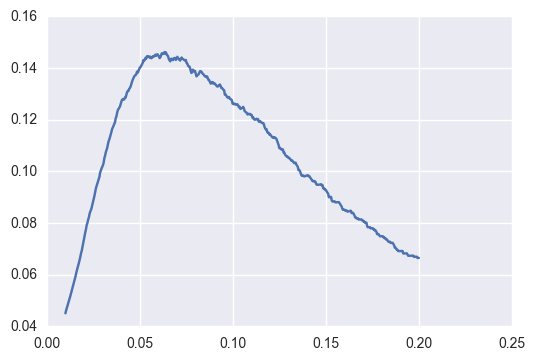

In [118]:
print('Validaion')
val_best_threshold = f1_best_threshold(y_val, val_preds)

In [119]:
feature_list = X_val[features].columns.values
df_fi = pd.DataFrame(bst.feature_importance(), columns=['importance'])
df_fi['feature'] = feature_list
df_fi = df_fi.sort_values('importance', ascending = 0)
df_fi[df_fi.importance >= 10]

,importance,feature
105,4731,UniqueUserDeviceKey
71,3731,LifeTimeImpressionCount
52,3727,ISOCountryShortName
0,3577,creativeName
32,3421,OSOOBEDateTimeDay
33,3017,CampaignIdValueCount
42,3000,ProcessorClockSpeed
65,3000,CampaignId
68,2994,DeviceTimezone
86,2982,FirstUpdatedDateDay


In [120]:
zeroImportance = df_fi[df_fi.importance == 0]['feature'].values
print(len(zeroImportance))

0


In [121]:
with Timer('# predict test data'):
    preds = bst.predict(test[features], num_iteration=bst.best_iteration)

# predict test data...
2017-03-21 00:06:20.166510
# predict test data: cpu 96.03, time 96.05



In [122]:
#print(bestEpsilon)
print(val_best_threshold)

0.0633066132265


In [123]:
test_id = test.RowNumber.values
submission = pd.DataFrame({'RowNumber': test_id})
submission['HasClicked'] = preds > val_best_threshold
print("Click mean:", submission.HasClicked.mean())
print("Submission file...")
submission.to_csv("W10_Coin_LightGBM_FinalV4.csv", index = False)
submission.head()

Click mean: 0.0191106466348
Submission file...


,RowNumber,HasClicked
0,1,False
1,2,False
2,3,False
3,4,False
4,5,False
